In [1]:
# ML_in_Finance-Autoencoders
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# tensorflow=2.0.0, keras=2.3.1, scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, pandas=1.0.3, seaborn=0.10.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020. 

# Introduction

The purpose of this notebook is to first review PCA for yield curve dimension reduction. Linear autoencoders are then compared with PCA. Finally we evaluate deep autoencoders for yield curve compression.

# PCA
Principal component analysis requires finding the weights which maximize the maximum weighted variance of the data $Y$: 
$$\max_{w:||w||=1}Var(w^TY) = \max_{w:||w||=1}w^TVar(Y)w$$

Setting $w=v$, with $v$ the eigenvector corresponding to the largest eigenvalue $\lambda$ of $C:=Var(Y)$ will yield an orthogonal projection which is an optimal solution. From the eigenvalue problem, we can obtain the eigenvalues of $V$:

$$C v=\lambda v$$
$$(C-\lambda I)v=0$$
$$ |C-\lambda I|=0$$

Plugging the eigenvalues into second equation above gives the eigenvectors. The result can be written as:

$$\Lambda=V^TCV,$$

where $\Lambda$ is the diagonal matrix of descending eigenvalues and $P$ is the corresponding orthornormal matrix of eigenvectors. Rearanging gives the spectral decomposition of the covariance matrix.

$$C=P\Lambda P^T$$.

The transformation of Y onto the orthonormal basis spanned by the columns of $P$ is:
$$X=P^TY$$

# Libs & Defs

In [2]:
from keras.layers import Input, Dense
from keras import regularizers, models, optimizers

from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

Using TensorFlow backend.
/Users/matthewdixon/miniconda3/envs/MLFTEST/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
%matplotlib inline

We define a linear autoencoder model with Keras. The autoencoder tries to map the input data set back onto itself, via a reduced dimensionality representation in its single hidden layer. 

In training, the weights are therefore tuned to find a reduced set of features which retain as much as possible of the variance in the original dataset. 

In [5]:
def LinearAE(y, dimension, learning_rate = 1e-4, regularization = 1e-5, epochs=10):
    
    input_layer = Input(shape=(y.shape[1],))
    
    # the encoder layer transforms the input into a representation of size `dimension`
    encoder = Dense(dimension, activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(input_layer)
    
    # the decoder layer transforms the encoded representation back to the original size
    decoder = Dense(y.shape[1], activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(encoder)
    
    autoencoder = models.Model(input_layer, decoder)
    autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate), loss='mean_squared_error')
    
    # the autoencoder aims to map the input back onto 
    # itself: the input data are also the output targets
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

# Load Dataset

In [6]:
df = pd.read_csv('../data/yield_curve.csv', sep=',')

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

df.set_index('Date', drop=True, inplace=True)

df.index.names = [None]

df.drop('Index', axis=1, inplace=True)

n_obs = len(df)

##### Uncomment the `elif (...)` line to perform PCA on the daily yield changes $\Delta Y_0$:

In [7]:
if len(df) == n_obs - 1: print('differences already taken')
#elif len(df) == n_obs: df = df.diff(1).iloc[1:]

In [8]:
df.head()

,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


## Visualizing the Dataset

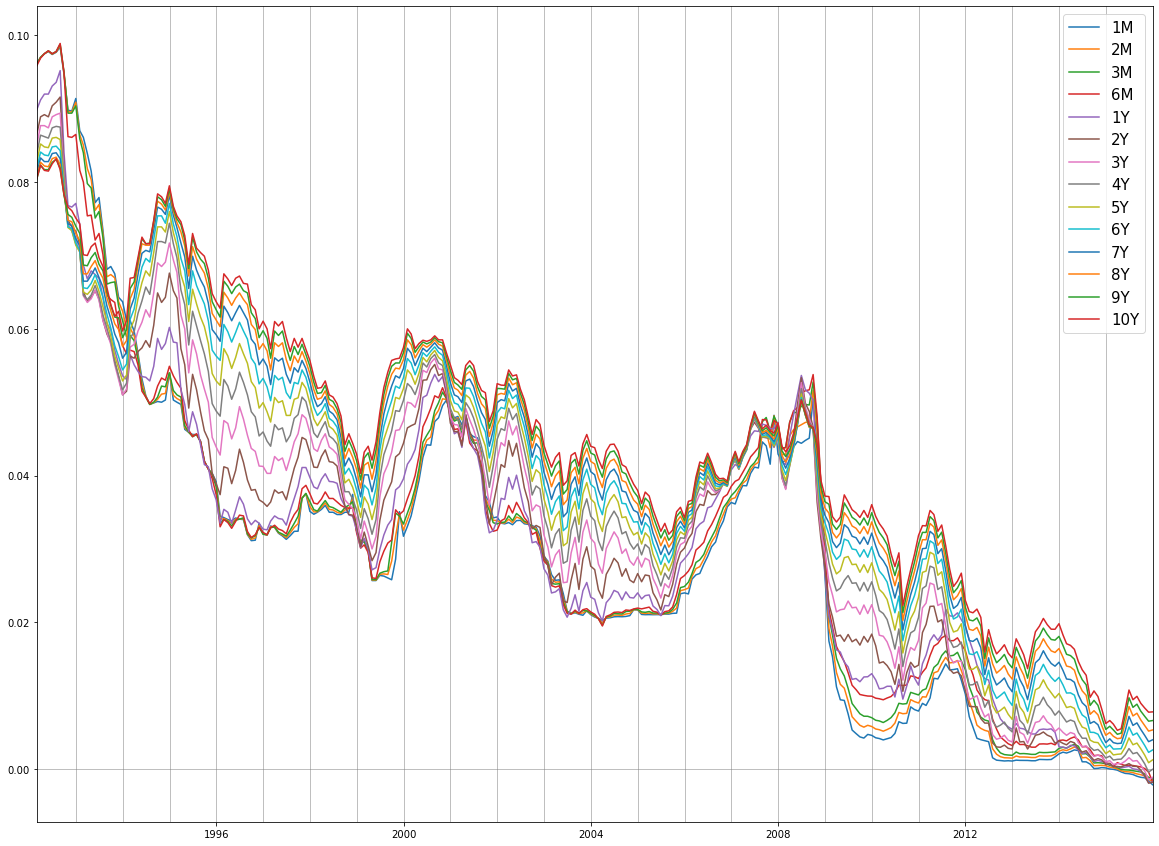

In [9]:
plt.figure(figsize=(20, 15))

plt.plot(df.index, df)

plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
plt.legend(df.columns, fontsize=15)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=datetime(i, 1, 1), c="grey", linewidth=0.5, zorder=0)

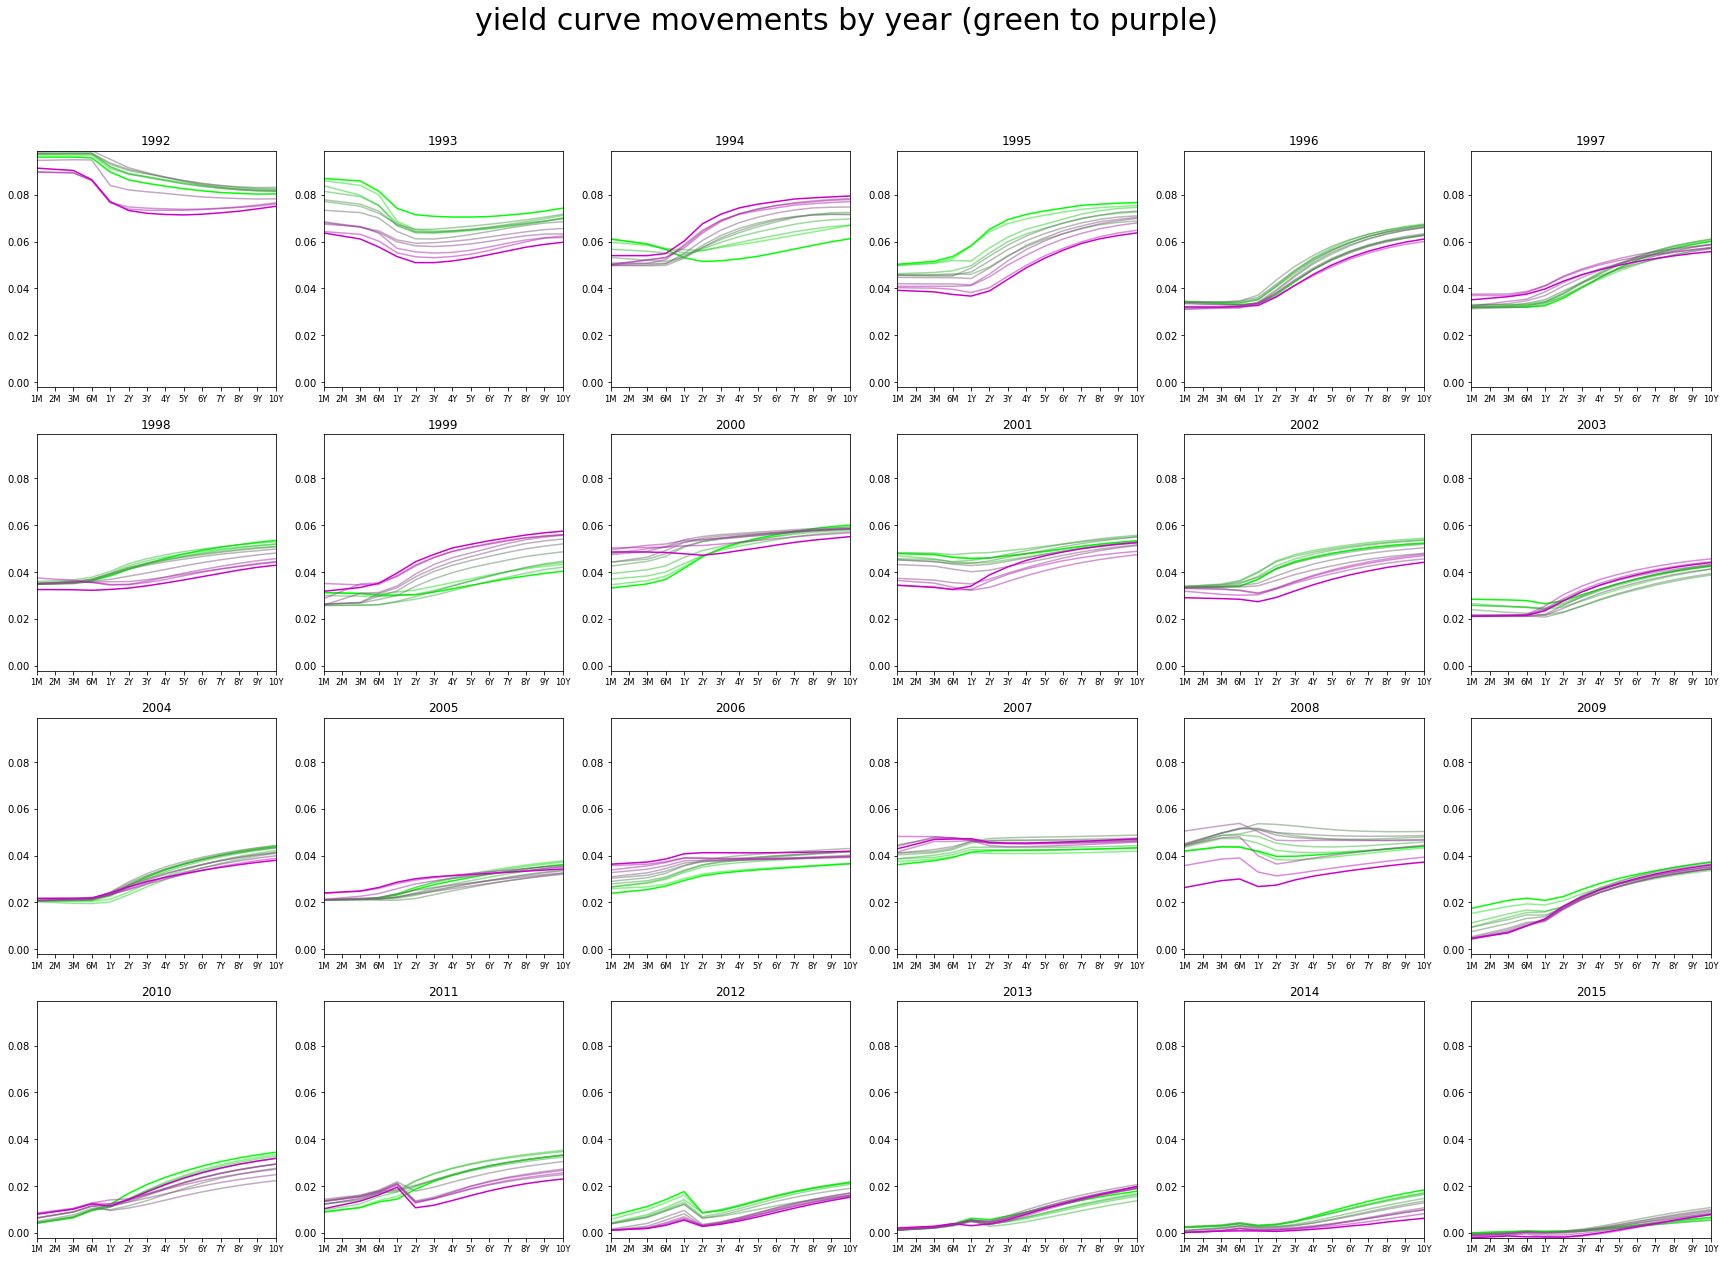

In [10]:
cols = 6
num_years = df.index.max().year - df.index.min().year
rows = int(np.ceil(num_years/cols))

# each line is a yield curve at a given time; each year begins green and ends purple
plt.figure(figsize=(30, (30/cols)*rows))
plt.suptitle('yield curve movements by year (green to purple)', fontsize=30)

colnum = 0
rownum = 0
for year in range(df.index.min().year, df.index.max().year+1):
    year_start = datetime(year, 1, 1)
    year_end = datetime(year, 12, 31)
    
    plt.subplot2grid((rows, cols), (rownum, colnum), colspan=1, rowspan=1)
    plt.title('{0}'.format(year))
    plt.xlim(0, len(df.columns)-1)
    plt.ylim(np.min(df.values), np.max(df.values))
    plt.xticks(range(len(df.columns)), df.columns, size='small')
    
    year_curves = df.loc[year_start:year_end].values    
    gradient = np.linspace([0, 1, 0, 1], [0.8, 0, 0.8, 1], year_curves.shape[0])
    gradient[1:-1, -1] = 0.5
    
    for yield_curve, colour in zip(year_curves, gradient):
        plt.plot(yield_curve, c=colour)

    if colnum != cols-1:
        colnum += 1
    else:
        colnum = 0
        rownum += 1

# Projection onto Principal Components

In [11]:
# calculate the first three PCs (Eigenvectors & Eigenvalues of the covariance matrix)
pca_model = PCA(n_components=3, copy=True, whiten=False)
pca_model.fit(df)

# project the dataset onto the principal components
df_pca = pd.DataFrame(pca_model.transform(df), index=df.index)

# transform the projections back into the input space
df_pca_recon = pd.DataFrame(pca_model.inverse_transform(df_pca), index=df.index, columns=df.columns)

In [12]:
df_pca.head()

,0,1,2
1992-02-29,0.189681,0.031657,-0.002092
1992-03-31,0.196655,0.029239,-0.003471
1992-04-30,0.196720,0.031033,-0.003950
1992-05-31,0.196820,0.031674,-0.003434
1992-06-30,0.199527,0.029321,-0.005054


## Plot the reconstruction error per variable for PCA

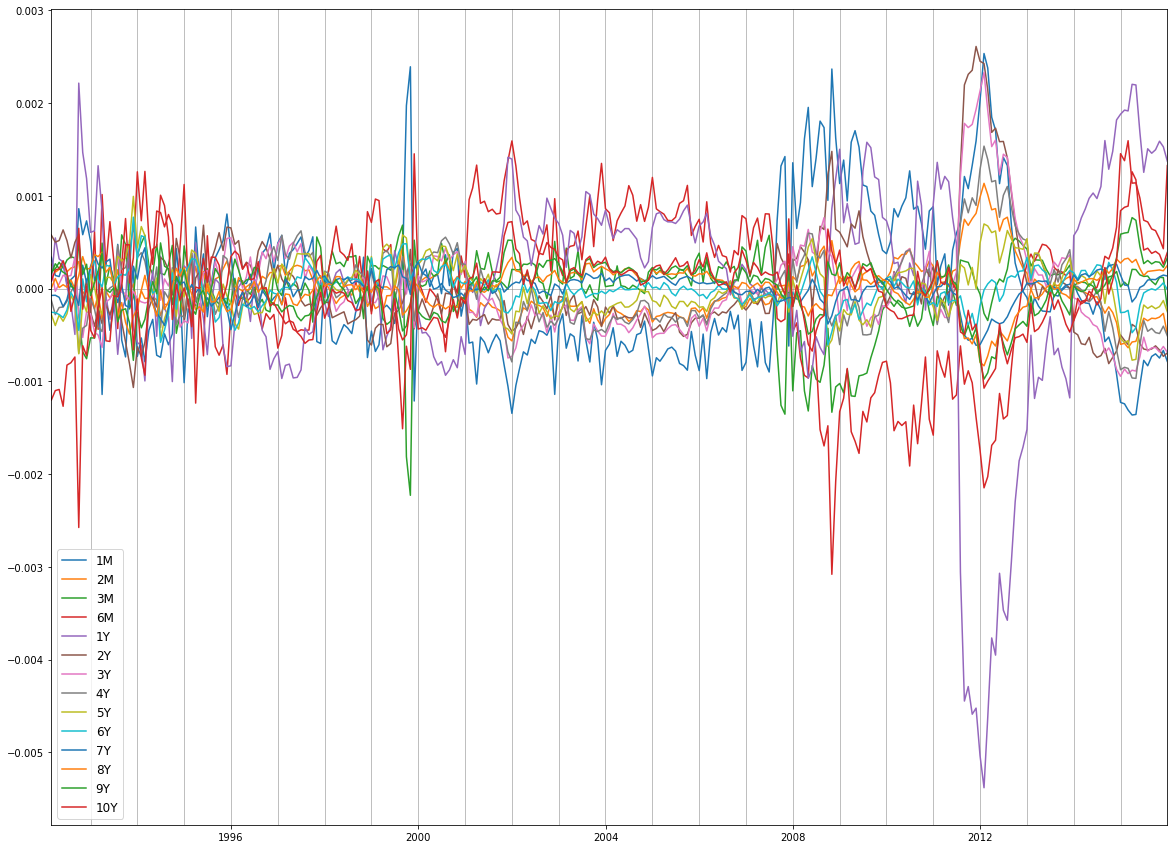

In [13]:
plt.figure(figsize=(20,15))

# Plotting the difference between the reconstructed value and the original
plt.plot(df.index, df_pca_recon-df.values)
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

### Evaluate the amount of variance explained by each component

In [14]:
for i, pc in enumerate(pca_model.explained_variance_ratio_):
    print('PC {0}:\t{1:5.2f}%'.format(i+1, pc*100.0))

PC 1:	95.53%
PC 2:	 4.07%
PC 3:	 0.33%


### Plot the loading vectors

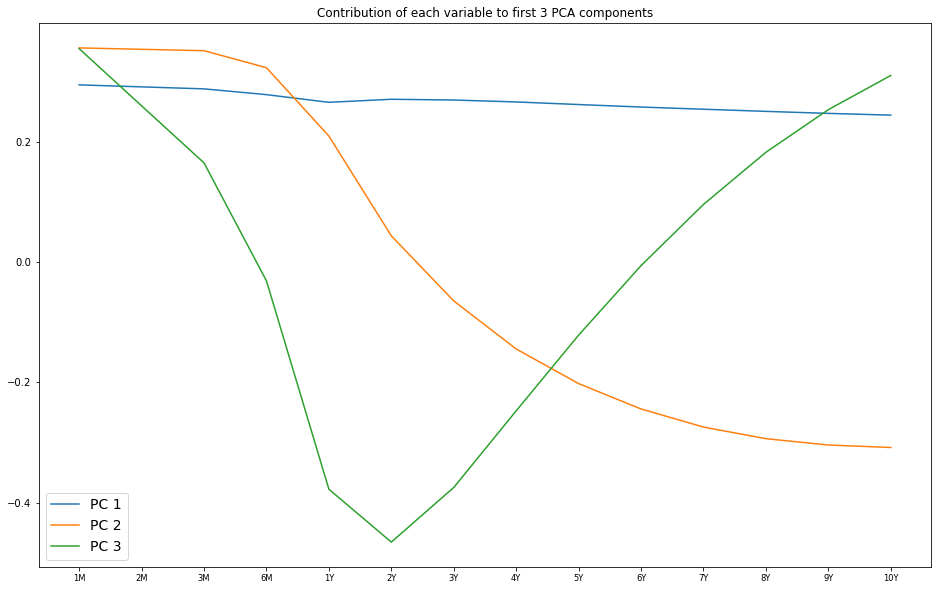

In [15]:
fig = plt.figure(figsize=(16,10))
plt.title('Contribution of each variable to first {0} PCA components'.format(pca_model.n_components))

plt.plot(np.transpose(pca_model.components_[0]), label='PC 1')
plt.plot(np.transpose(pca_model.components_[1]), label='PC 2')
plt.plot(np.transpose(pca_model.components_[2]), label='PC 3')
plt.xticks(range(len(df.columns)), df.columns, size='small')

plt.legend(fontsize=14);

From the graph it can be seen that, roughly speaking, the PCA representation encodes the yield curves' shapes in terms of their "height" (PC 1), "slope" (PC 2), and "V-shaped-ness" (PC 3)

# Linear Autoencoders

### Fit the linear auto-encoder

In [16]:
ae_model = LinearAE(df.values, 3, regularization=0, epochs=2000)
(w1, b1, w2, b2) = ae_model.get_weights()

Epoch 1/2000
287/287 [==============================] - 1s 3ms/step - loss: 0.0019
Epoch 2/2000
287/287 [==============================] - 0s 518us/step - loss: 0.0013
Epoch 3/2000
287/287 [==============================] - 0s 538us/step - loss: 0.0010
Epoch 4/2000
287/287 [==============================] - 0s 541us/step - loss: 7.7719e-04
Epoch 5/2000
287/287 [==============================] - 0s 575us/step - loss: 6.2855e-04
Epoch 6/2000
287/287 [==============================] - 0s 594us/step - loss: 5.3275e-04
Epoch 7/2000
287/287 [==============================] - 0s 557us/step - loss: 4.6967e-04
Epoch 8/2000
287/287 [==============================] - 0s 571us/step - loss: 4.3054e-04
Epoch 9/2000
287/287 [==============================] - 0s 567us/step - loss: 4.0460e-04
Epoch 10/2000
287/287 [==============================] - 0s 554us/step - loss: 3.8799e-04
Epoch 11/2000
287/287 [==============================] - 0s 599us/step - loss: 3.7630e-04
Epoch 12/2000
287/287 [==========

287/287 [==============================] - 0s 522us/step - loss: 1.9829e-05
Epoch 93/2000
287/287 [==============================] - 0s 508us/step - loss: 1.9964e-05
Epoch 94/2000
287/287 [==============================] - 0s 520us/step - loss: 1.9630e-05
Epoch 95/2000
287/287 [==============================] - 0s 521us/step - loss: 1.9542e-05
Epoch 96/2000
287/287 [==============================] - 0s 525us/step - loss: 1.9505e-05
Epoch 97/2000
287/287 [==============================] - 0s 524us/step - loss: 1.9525e-05
Epoch 98/2000
287/287 [==============================] - 0s 509us/step - loss: 1.9310e-05
Epoch 99/2000
287/287 [==============================] - 0s 491us/step - loss: 1.9459e-05
Epoch 100/2000
287/287 [==============================] - 0s 489us/step - loss: 1.9352e-05
Epoch 101/2000
287/287 [==============================] - 0s 484us/step - loss: 1.9154e-05
Epoch 102/2000
287/287 [==============================] - 0s 516us/step - loss: 1.9390e-05
Epoch 103/2000
287/28

287/287 [==============================] - 0s 514us/step - loss: 1.2051e-05
Epoch 182/2000
287/287 [==============================] - 0s 480us/step - loss: 1.1945e-05
Epoch 183/2000
287/287 [==============================] - 0s 471us/step - loss: 1.1773e-05
Epoch 184/2000
287/287 [==============================] - 0s 486us/step - loss: 1.1761e-05
Epoch 185/2000
287/287 [==============================] - 0s 520us/step - loss: 1.1687e-05
Epoch 186/2000
287/287 [==============================] - 0s 557us/step - loss: 1.1447e-05
Epoch 187/2000
287/287 [==============================] - 0s 562us/step - loss: 1.1279e-05
Epoch 188/2000
287/287 [==============================] - 0s 561us/step - loss: 1.1219e-05
Epoch 189/2000
287/287 [==============================] - 0s 468us/step - loss: 1.1224e-05
Epoch 190/2000
287/287 [==============================] - 0s 471us/step - loss: 1.0979e-05
Epoch 191/2000
287/287 [==============================] - 0s 488us/step - loss: 1.0870e-05
Epoch 192/2000

287/287 [==============================] - 0s 532us/step - loss: 3.3832e-06
Epoch 272/2000
287/287 [==============================] - 0s 545us/step - loss: 3.3376e-06
Epoch 273/2000
287/287 [==============================] - 0s 534us/step - loss: 3.2532e-06
Epoch 274/2000
287/287 [==============================] - 0s 541us/step - loss: 3.2210e-06
Epoch 275/2000
287/287 [==============================] - 0s 551us/step - loss: 3.1644e-06
Epoch 276/2000
287/287 [==============================] - 0s 526us/step - loss: 3.1132e-06
Epoch 277/2000
287/287 [==============================] - 0s 542us/step - loss: 3.0495e-06
Epoch 278/2000
287/287 [==============================] - 0s 520us/step - loss: 3.0337e-06
Epoch 279/2000
287/287 [==============================] - 0s 516us/step - loss: 2.9757e-06
Epoch 280/2000
287/287 [==============================] - 0s 514us/step - loss: 2.9397e-06
Epoch 281/2000
287/287 [==============================] - 0s 528us/step - loss: 2.8968e-06
Epoch 282/2000

287/287 [==============================] - 0s 518us/step - loss: 1.8258e-06
Epoch 362/2000
287/287 [==============================] - 0s 566us/step - loss: 1.8267e-06
Epoch 363/2000
287/287 [==============================] - 0s 631us/step - loss: 1.8179e-06
Epoch 364/2000
287/287 [==============================] - 0s 622us/step - loss: 1.8046e-06
Epoch 365/2000
287/287 [==============================] - 0s 535us/step - loss: 1.8346e-06
Epoch 366/2000
287/287 [==============================] - 0s 514us/step - loss: 1.8014e-06
Epoch 367/2000
287/287 [==============================] - 0s 499us/step - loss: 1.7968e-06
Epoch 368/2000
287/287 [==============================] - 0s 512us/step - loss: 1.7727e-06
Epoch 369/2000
287/287 [==============================] - 0s 497us/step - loss: 1.8567e-06
Epoch 370/2000
287/287 [==============================] - 0s 539us/step - loss: 1.7994e-06
Epoch 371/2000
287/287 [==============================] - 0s 508us/step - loss: 1.7997e-06
Epoch 372/2000

287/287 [==============================] - 0s 494us/step - loss: 1.7987e-06
Epoch 452/2000
287/287 [==============================] - 0s 471us/step - loss: 1.7707e-06
Epoch 453/2000
287/287 [==============================] - 0s 498us/step - loss: 1.7740e-06
Epoch 454/2000
287/287 [==============================] - 0s 464us/step - loss: 1.7972e-06
Epoch 455/2000
287/287 [==============================] - 0s 488us/step - loss: 1.7598e-06
Epoch 456/2000
287/287 [==============================] - 0s 449us/step - loss: 1.7828e-06
Epoch 457/2000
287/287 [==============================] - 0s 455us/step - loss: 1.7763e-06
Epoch 458/2000
287/287 [==============================] - 0s 476us/step - loss: 1.7721e-06
Epoch 459/2000
287/287 [==============================] - 0s 552us/step - loss: 1.7496e-06
Epoch 460/2000
287/287 [==============================] - 0s 494us/step - loss: 1.7899e-06
Epoch 461/2000
287/287 [==============================] - 0s 499us/step - loss: 1.7577e-06
Epoch 462/2000

287/287 [==============================] - 0s 455us/step - loss: 1.7426e-06
Epoch 542/2000
287/287 [==============================] - 0s 442us/step - loss: 1.7493e-06
Epoch 543/2000
287/287 [==============================] - 0s 444us/step - loss: 1.7756e-06
Epoch 544/2000
287/287 [==============================] - 0s 422us/step - loss: 1.7446e-06
Epoch 545/2000
287/287 [==============================] - 0s 445us/step - loss: 1.7579e-06
Epoch 546/2000
287/287 [==============================] - 0s 453us/step - loss: 1.7838e-06
Epoch 547/2000
287/287 [==============================] - 0s 447us/step - loss: 1.7797e-06
Epoch 548/2000
287/287 [==============================] - 0s 529us/step - loss: 1.7952e-06
Epoch 549/2000
287/287 [==============================] - 0s 448us/step - loss: 1.7616e-06
Epoch 550/2000
287/287 [==============================] - 0s 441us/step - loss: 1.7969e-06
Epoch 551/2000
287/287 [==============================] - 0s 450us/step - loss: 1.7651e-06
Epoch 552/2000

287/287 [==============================] - 0s 503us/step - loss: 1.7361e-06
Epoch 632/2000
287/287 [==============================] - 0s 467us/step - loss: 1.7508e-06
Epoch 633/2000
287/287 [==============================] - 0s 449us/step - loss: 1.7568e-06
Epoch 634/2000
287/287 [==============================] - 0s 491us/step - loss: 1.7655e-06
Epoch 635/2000
287/287 [==============================] - 0s 514us/step - loss: 1.7686e-06
Epoch 636/2000
287/287 [==============================] - 0s 491us/step - loss: 1.7558e-06
Epoch 637/2000
287/287 [==============================] - 0s 493us/step - loss: 1.7471e-06
Epoch 638/2000
287/287 [==============================] - 0s 472us/step - loss: 1.7960e-06
Epoch 639/2000
287/287 [==============================] - 0s 451us/step - loss: 1.7494e-06
Epoch 640/2000
287/287 [==============================] - 0s 462us/step - loss: 1.7427e-06
Epoch 641/2000
287/287 [==============================] - 0s 494us/step - loss: 1.7744e-06
Epoch 642/2000

287/287 [==============================] - 0s 463us/step - loss: 1.7715e-06
Epoch 722/2000
287/287 [==============================] - 0s 453us/step - loss: 1.7711e-06
Epoch 723/2000
287/287 [==============================] - 0s 446us/step - loss: 1.7680e-06
Epoch 724/2000
287/287 [==============================] - 0s 460us/step - loss: 1.7480e-06
Epoch 725/2000
287/287 [==============================] - 0s 463us/step - loss: 1.7603e-06
Epoch 726/2000
287/287 [==============================] - 0s 447us/step - loss: 1.7527e-06
Epoch 727/2000
287/287 [==============================] - 0s 447us/step - loss: 1.7891e-06
Epoch 728/2000
287/287 [==============================] - 0s 447us/step - loss: 1.7486e-06
Epoch 729/2000
287/287 [==============================] - 0s 472us/step - loss: 1.7500e-06
Epoch 730/2000
287/287 [==============================] - 0s 483us/step - loss: 1.7492e-06
Epoch 731/2000
287/287 [==============================] - 0s 468us/step - loss: 1.7654e-06
Epoch 732/2000

287/287 [==============================] - 0s 464us/step - loss: 1.7364e-06
Epoch 812/2000
287/287 [==============================] - 0s 456us/step - loss: 1.7582e-06
Epoch 813/2000
287/287 [==============================] - 0s 467us/step - loss: 1.7473e-06
Epoch 814/2000
287/287 [==============================] - 0s 464us/step - loss: 1.7568e-06
Epoch 815/2000
287/287 [==============================] - 0s 439us/step - loss: 1.7497e-06
Epoch 816/2000
287/287 [==============================] - 0s 467us/step - loss: 1.7791e-06
Epoch 817/2000
287/287 [==============================] - 0s 472us/step - loss: 1.7483e-06
Epoch 818/2000
287/287 [==============================] - 0s 513us/step - loss: 1.7420e-06
Epoch 819/2000
287/287 [==============================] - 0s 467us/step - loss: 1.7542e-06
Epoch 820/2000
287/287 [==============================] - 0s 469us/step - loss: 1.7487e-06
Epoch 821/2000
287/287 [==============================] - 0s 466us/step - loss: 1.7504e-06
Epoch 822/2000

287/287 [==============================] - 0s 466us/step - loss: 1.7824e-06
Epoch 902/2000
287/287 [==============================] - 0s 455us/step - loss: 1.7409e-06
Epoch 903/2000
287/287 [==============================] - 0s 482us/step - loss: 1.7356e-06
Epoch 904/2000
287/287 [==============================] - 0s 479us/step - loss: 1.7456e-06
Epoch 905/2000
287/287 [==============================] - 0s 512us/step - loss: 1.7478e-06
Epoch 906/2000
287/287 [==============================] - 0s 500us/step - loss: 1.7481e-06
Epoch 907/2000
287/287 [==============================] - 0s 449us/step - loss: 1.7832e-06
Epoch 908/2000
287/287 [==============================] - 0s 449us/step - loss: 1.7569e-06
Epoch 909/2000
287/287 [==============================] - 0s 453us/step - loss: 1.7556e-06
Epoch 910/2000
287/287 [==============================] - 0s 479us/step - loss: 1.7685e-06
Epoch 911/2000
287/287 [==============================] - 0s 501us/step - loss: 1.7995e-06
Epoch 912/2000

287/287 [==============================] - 0s 453us/step - loss: 1.7564e-06
Epoch 992/2000
287/287 [==============================] - 0s 489us/step - loss: 1.7572e-06
Epoch 993/2000
287/287 [==============================] - 0s 455us/step - loss: 1.7589e-06
Epoch 994/2000
287/287 [==============================] - 0s 457us/step - loss: 1.7486e-06
Epoch 995/2000
287/287 [==============================] - 0s 503us/step - loss: 1.7662e-06
Epoch 996/2000
287/287 [==============================] - 0s 580us/step - loss: 1.7667e-06
Epoch 997/2000
287/287 [==============================] - 0s 516us/step - loss: 1.7480e-06
Epoch 998/2000
287/287 [==============================] - 0s 510us/step - loss: 1.7419e-06
Epoch 999/2000
287/287 [==============================] - 0s 505us/step - loss: 1.7308e-06
Epoch 1000/2000
287/287 [==============================] - 0s 503us/step - loss: 1.7525e-06
Epoch 1001/2000
287/287 [==============================] - 0s 488us/step - loss: 1.7540e-06
Epoch 1002/2

287/287 [==============================] - 0s 454us/step - loss: 1.7400e-06
Epoch 1081/2000
287/287 [==============================] - 0s 460us/step - loss: 1.7727e-06
Epoch 1082/2000
287/287 [==============================] - 0s 456us/step - loss: 1.7403e-06
Epoch 1083/2000
287/287 [==============================] - 0s 475us/step - loss: 1.7288e-06
Epoch 1084/2000
287/287 [==============================] - 0s 488us/step - loss: 1.7417e-06
Epoch 1085/2000
287/287 [==============================] - 0s 477us/step - loss: 1.7445e-06
Epoch 1086/2000
287/287 [==============================] - 0s 451us/step - loss: 1.7479e-06
Epoch 1087/2000
287/287 [==============================] - 0s 470us/step - loss: 1.7432e-06
Epoch 1088/2000
287/287 [==============================] - 0s 514us/step - loss: 1.7516e-06
Epoch 1089/2000
287/287 [==============================] - 0s 456us/step - loss: 1.7551e-06
Epoch 1090/2000
287/287 [==============================] - 0s 490us/step - loss: 1.7619e-06
Epoc

287/287 [==============================] - 0s 551us/step - loss: 1.7418e-06
Epoch 1170/2000
287/287 [==============================] - 0s 512us/step - loss: 1.7427e-06
Epoch 1171/2000
287/287 [==============================] - 0s 574us/step - loss: 1.7383e-06
Epoch 1172/2000
287/287 [==============================] - 0s 497us/step - loss: 1.7711e-06
Epoch 1173/2000
287/287 [==============================] - 0s 514us/step - loss: 1.7330e-06
Epoch 1174/2000
287/287 [==============================] - 0s 522us/step - loss: 1.7445e-06
Epoch 1175/2000
287/287 [==============================] - 0s 507us/step - loss: 1.7503e-06
Epoch 1176/2000
287/287 [==============================] - 0s 517us/step - loss: 1.7422e-06
Epoch 1177/2000
287/287 [==============================] - 0s 485us/step - loss: 1.8203e-06
Epoch 1178/2000
287/287 [==============================] - 0s 470us/step - loss: 1.7486e-06
Epoch 1179/2000
287/287 [==============================] - 0s 487us/step - loss: 1.7558e-06
Epoc

287/287 [==============================] - 0s 498us/step - loss: 1.7750e-06
Epoch 1259/2000
287/287 [==============================] - 0s 494us/step - loss: 1.7496e-06
Epoch 1260/2000
287/287 [==============================] - 0s 510us/step - loss: 1.7515e-06
Epoch 1261/2000
287/287 [==============================] - 0s 506us/step - loss: 1.7378e-06
Epoch 1262/2000
287/287 [==============================] - 0s 492us/step - loss: 1.7495e-06
Epoch 1263/2000
287/287 [==============================] - 0s 521us/step - loss: 1.7345e-06
Epoch 1264/2000
287/287 [==============================] - 0s 521us/step - loss: 1.7444e-06
Epoch 1265/2000
287/287 [==============================] - 0s 541us/step - loss: 1.7380e-06
Epoch 1266/2000
287/287 [==============================] - 0s 541us/step - loss: 1.7396e-06
Epoch 1267/2000
287/287 [==============================] - 0s 537us/step - loss: 1.7101e-06
Epoch 1268/2000
287/287 [==============================] - 0s 501us/step - loss: 1.7424e-06
Epoc

287/287 [==============================] - 0s 476us/step - loss: 1.7480e-06
Epoch 1347/2000
287/287 [==============================] - 0s 467us/step - loss: 1.7136e-06
Epoch 1348/2000
287/287 [==============================] - 0s 480us/step - loss: 1.7975e-06
Epoch 1349/2000
287/287 [==============================] - 0s 473us/step - loss: 1.7342e-06
Epoch 1350/2000
287/287 [==============================] - 0s 563us/step - loss: 1.7635e-06
Epoch 1351/2000
287/287 [==============================] - 0s 519us/step - loss: 1.7568e-06
Epoch 1352/2000
287/287 [==============================] - 0s 510us/step - loss: 1.7455e-06
Epoch 1353/2000
287/287 [==============================] - 0s 490us/step - loss: 1.7376e-06
Epoch 1354/2000
287/287 [==============================] - 0s 477us/step - loss: 1.7339e-06
Epoch 1355/2000
287/287 [==============================] - 0s 517us/step - loss: 1.7294e-06
Epoch 1356/2000
287/287 [==============================] - 0s 553us/step - loss: 1.7239e-06
Epoc

287/287 [==============================] - 0s 465us/step - loss: 1.7428e-06
Epoch 1436/2000
287/287 [==============================] - 0s 456us/step - loss: 1.7529e-06
Epoch 1437/2000
287/287 [==============================] - 0s 464us/step - loss: 1.7125e-06
Epoch 1438/2000
287/287 [==============================] - 0s 456us/step - loss: 1.7544e-06
Epoch 1439/2000
287/287 [==============================] - 0s 460us/step - loss: 1.7661e-06
Epoch 1440/2000
287/287 [==============================] - 0s 461us/step - loss: 1.7320e-06
Epoch 1441/2000
287/287 [==============================] - 0s 447us/step - loss: 1.7229e-06
Epoch 1442/2000
287/287 [==============================] - 0s 479us/step - loss: 1.7561e-06
Epoch 1443/2000
287/287 [==============================] - 0s 461us/step - loss: 1.7447e-06
Epoch 1444/2000
287/287 [==============================] - 0s 463us/step - loss: 1.7653e-06
Epoch 1445/2000
287/287 [==============================] - 0s 479us/step - loss: 1.7377e-06
Epoc

287/287 [==============================] - 0s 465us/step - loss: 1.7518e-06
Epoch 1525/2000
287/287 [==============================] - 0s 479us/step - loss: 1.7415e-06
Epoch 1526/2000
287/287 [==============================] - 0s 470us/step - loss: 1.7350e-06
Epoch 1527/2000
287/287 [==============================] - 0s 468us/step - loss: 1.7599e-06
Epoch 1528/2000
287/287 [==============================] - 0s 495us/step - loss: 1.7316e-06
Epoch 1529/2000
287/287 [==============================] - 0s 507us/step - loss: 1.7311e-06
Epoch 1530/2000
287/287 [==============================] - 0s 466us/step - loss: 1.7408e-06
Epoch 1531/2000
287/287 [==============================] - 0s 491us/step - loss: 1.7441e-06
Epoch 1532/2000
287/287 [==============================] - 0s 453us/step - loss: 1.7478e-06
Epoch 1533/2000
287/287 [==============================] - 0s 460us/step - loss: 1.7329e-06
Epoch 1534/2000
287/287 [==============================] - 0s 481us/step - loss: 1.7752e-06
Epoc

287/287 [==============================] - 0s 450us/step - loss: 1.7633e-06
Epoch 1614/2000
287/287 [==============================] - 0s 486us/step - loss: 1.7230e-06
Epoch 1615/2000
287/287 [==============================] - 0s 477us/step - loss: 1.7384e-06
Epoch 1616/2000
287/287 [==============================] - 0s 479us/step - loss: 1.7192e-06
Epoch 1617/2000
287/287 [==============================] - 0s 526us/step - loss: 1.7370e-06
Epoch 1618/2000
287/287 [==============================] - 0s 495us/step - loss: 1.7356e-06
Epoch 1619/2000
287/287 [==============================] - 0s 515us/step - loss: 1.7370e-06
Epoch 1620/2000
287/287 [==============================] - 0s 549us/step - loss: 1.7317e-06 0s - loss: 1.5572e
Epoch 1621/2000
287/287 [==============================] - 0s 555us/step - loss: 1.7421e-06
Epoch 1622/2000
287/287 [==============================] - 0s 543us/step - loss: 1.7537e-06
Epoch 1623/2000
287/287 [==============================] - 0s 513us/step - lo

287/287 [==============================] - 0s 448us/step - loss: 1.7404e-06
Epoch 1703/2000
287/287 [==============================] - 0s 469us/step - loss: 1.7359e-06
Epoch 1704/2000
287/287 [==============================] - 0s 458us/step - loss: 1.7274e-06
Epoch 1705/2000
287/287 [==============================] - 0s 453us/step - loss: 1.7322e-06
Epoch 1706/2000
287/287 [==============================] - 0s 450us/step - loss: 1.7697e-06
Epoch 1707/2000
287/287 [==============================] - 0s 460us/step - loss: 1.7620e-06
Epoch 1708/2000
287/287 [==============================] - 0s 492us/step - loss: 1.7544e-06
Epoch 1709/2000
287/287 [==============================] - 0s 485us/step - loss: 1.7428e-06
Epoch 1710/2000
287/287 [==============================] - 0s 548us/step - loss: 1.7664e-06
Epoch 1711/2000
287/287 [==============================] - 0s 511us/step - loss: 1.8282e-06
Epoch 1712/2000
287/287 [==============================] - 0s 487us/step - loss: 1.7385e-06
Epoc

287/287 [==============================] - 0s 486us/step - loss: 1.7694e-06
Epoch 1792/2000
287/287 [==============================] - 0s 486us/step - loss: 1.7163e-06
Epoch 1793/2000
287/287 [==============================] - 0s 494us/step - loss: 1.7687e-06
Epoch 1794/2000
287/287 [==============================] - 0s 499us/step - loss: 1.7371e-06
Epoch 1795/2000
287/287 [==============================] - 0s 500us/step - loss: 1.7653e-06
Epoch 1796/2000
287/287 [==============================] - 0s 476us/step - loss: 1.7205e-06
Epoch 1797/2000
287/287 [==============================] - 0s 474us/step - loss: 1.7385e-06
Epoch 1798/2000
287/287 [==============================] - 0s 504us/step - loss: 1.8172e-06
Epoch 1799/2000
287/287 [==============================] - 0s 476us/step - loss: 1.7368e-06
Epoch 1800/2000
287/287 [==============================] - 0s 500us/step - loss: 1.7755e-06
Epoch 1801/2000
287/287 [==============================] - 0s 493us/step - loss: 1.7301e-06
Epoc

287/287 [==============================] - 0s 470us/step - loss: 1.7719e-06
Epoch 1881/2000
287/287 [==============================] - 0s 457us/step - loss: 1.7552e-06
Epoch 1882/2000
287/287 [==============================] - 0s 461us/step - loss: 1.7526e-06
Epoch 1883/2000
287/287 [==============================] - 0s 461us/step - loss: 1.7611e-06
Epoch 1884/2000
287/287 [==============================] - 0s 464us/step - loss: 1.7656e-06
Epoch 1885/2000
287/287 [==============================] - 0s 448us/step - loss: 1.7323e-06
Epoch 1886/2000
287/287 [==============================] - 0s 459us/step - loss: 1.7542e-06
Epoch 1887/2000
287/287 [==============================] - 0s 494us/step - loss: 1.7436e-06
Epoch 1888/2000
287/287 [==============================] - 0s 502us/step - loss: 1.7489e-06
Epoch 1889/2000
287/287 [==============================] - 0s 513us/step - loss: 1.7309e-06
Epoch 1890/2000
287/287 [==============================] - 0s 526us/step - loss: 1.7397e-06
Epoc

287/287 [==============================] - 0s 573us/step - loss: 1.7430e-06
Epoch 1970/2000
287/287 [==============================] - 0s 524us/step - loss: 1.7215e-06
Epoch 1971/2000
287/287 [==============================] - 0s 556us/step - loss: 1.7293e-06
Epoch 1972/2000
287/287 [==============================] - 0s 555us/step - loss: 1.7323e-06
Epoch 1973/2000
287/287 [==============================] - 0s 517us/step - loss: 1.7380e-06
Epoch 1974/2000
287/287 [==============================] - 0s 541us/step - loss: 1.7048e-06
Epoch 1975/2000
287/287 [==============================] - 0s 550us/step - loss: 1.7761e-06
Epoch 1976/2000
287/287 [==============================] - 0s 477us/step - loss: 1.7610e-06
Epoch 1977/2000
287/287 [==============================] - 0s 499us/step - loss: 1.7649e-06
Epoch 1978/2000
287/287 [==============================] - 0s 521us/step - loss: 1.7381e-06
Epoch 1979/2000
287/287 [==============================] - 0s 530us/step - loss: 1.7304e-06
Epoc

### Extract the left singular vectors of the decoder weight matrix

In [17]:
(ae_decoder_lsv, _, _) = np.linalg.svd(w2.T, full_matrices=False)

In [18]:
mu = np.mean(df.values, axis=0)
ae_lsv_projections = np.array(df.values-mu) @ ae_decoder_lsv

In [19]:
df_ae = pd.DataFrame(ae_lsv_projections, index=df.index)

### Compare the transformed sample covariances

The sample covariance matrix is given by C.

In [20]:
C = np.dot((df-mu).T, df-mu)

The total variance is given by the sum of the diagonal elements of the covariance matrix

In [21]:
total_variance = np.sum(np.diag(C))
print('total variance:', total_variance)

total variance: 1.7086096174655052


Diagonalize the sample covariance matrix with the m-loading vectors:
$$\text{P}_m^T \text{Y}_0 \text{Y}_0^T \text{P}_m$$

Begin with PCA:

In [22]:
Lambda_from_pca = pca_model.components_ @ C @ pca_model.components_.T

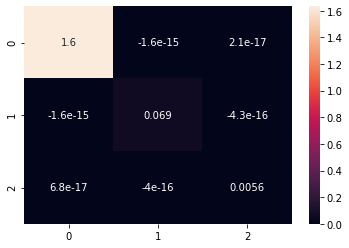

In [23]:
ax = sns.heatmap(Lambda_from_pca, annot=True)

Show the explained variances by each component (check with above)

In [24]:
print(100 * np.diag(Lambda_from_pca) / total_variance)
print('{:.6}% of total variance explained'.format(100 * np.sum(np.diag(Lambda_from_pca)) / total_variance))

[95.53366571  4.0667419   0.32890998]
99.9293% of total variance explained


Now perform the transformation of the covariance matrix using the decoder weights. Note that the matrix $\Lambda$ is no longer diagonal.

In [25]:
Lambda_from_decoder_weights = w2 @ C @ w2.T

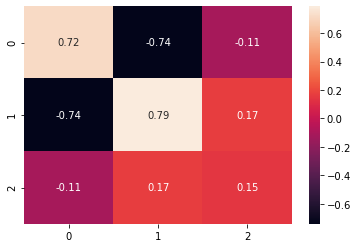

In [26]:
ax = sns.heatmap(Lambda_from_decoder_weights, annot=True)
plt.show()

Finally, perform the transformation of the covariance matrix using the left singular vectors of the decoder weights. The covariance matrix is not diagonalized, but the proportion of the variance explained by each sorted diagonal element is similar to values obtained by PCA.

In [27]:
Lambda_from_decoder_lsv = ae_decoder_lsv.T @ C @ ae_decoder_lsv

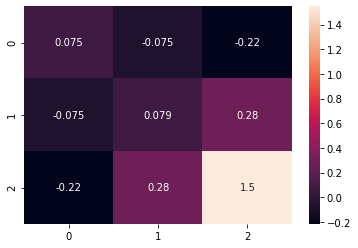

In [28]:
ax = sns.heatmap(Lambda_from_decoder_lsv, annot=True)
plt.show()

Show the explained variances by each diagonal component and compare with PCA.

In [29]:
print(100*np.diag(Lambda_from_decoder_lsv) / total_variance)
print('{:.6}% of total variance explained'.format(100*np.sum(np.diag(Lambda_from_decoder_lsv)) / total_variance))

[ 4.40268467  4.62306122 90.57724309]
99.603% of total variance explained


### Inspect the fit of the reconstructed data

First we get the reconstructed values from the trained model:

In [30]:
df_ae_recon = ae_model.predict(df.values)

Then we can plot the reconstructed values of each variable against its original value for every point. Differences introduced by the dimensionality reduction show up as deviation from the diagonal. 

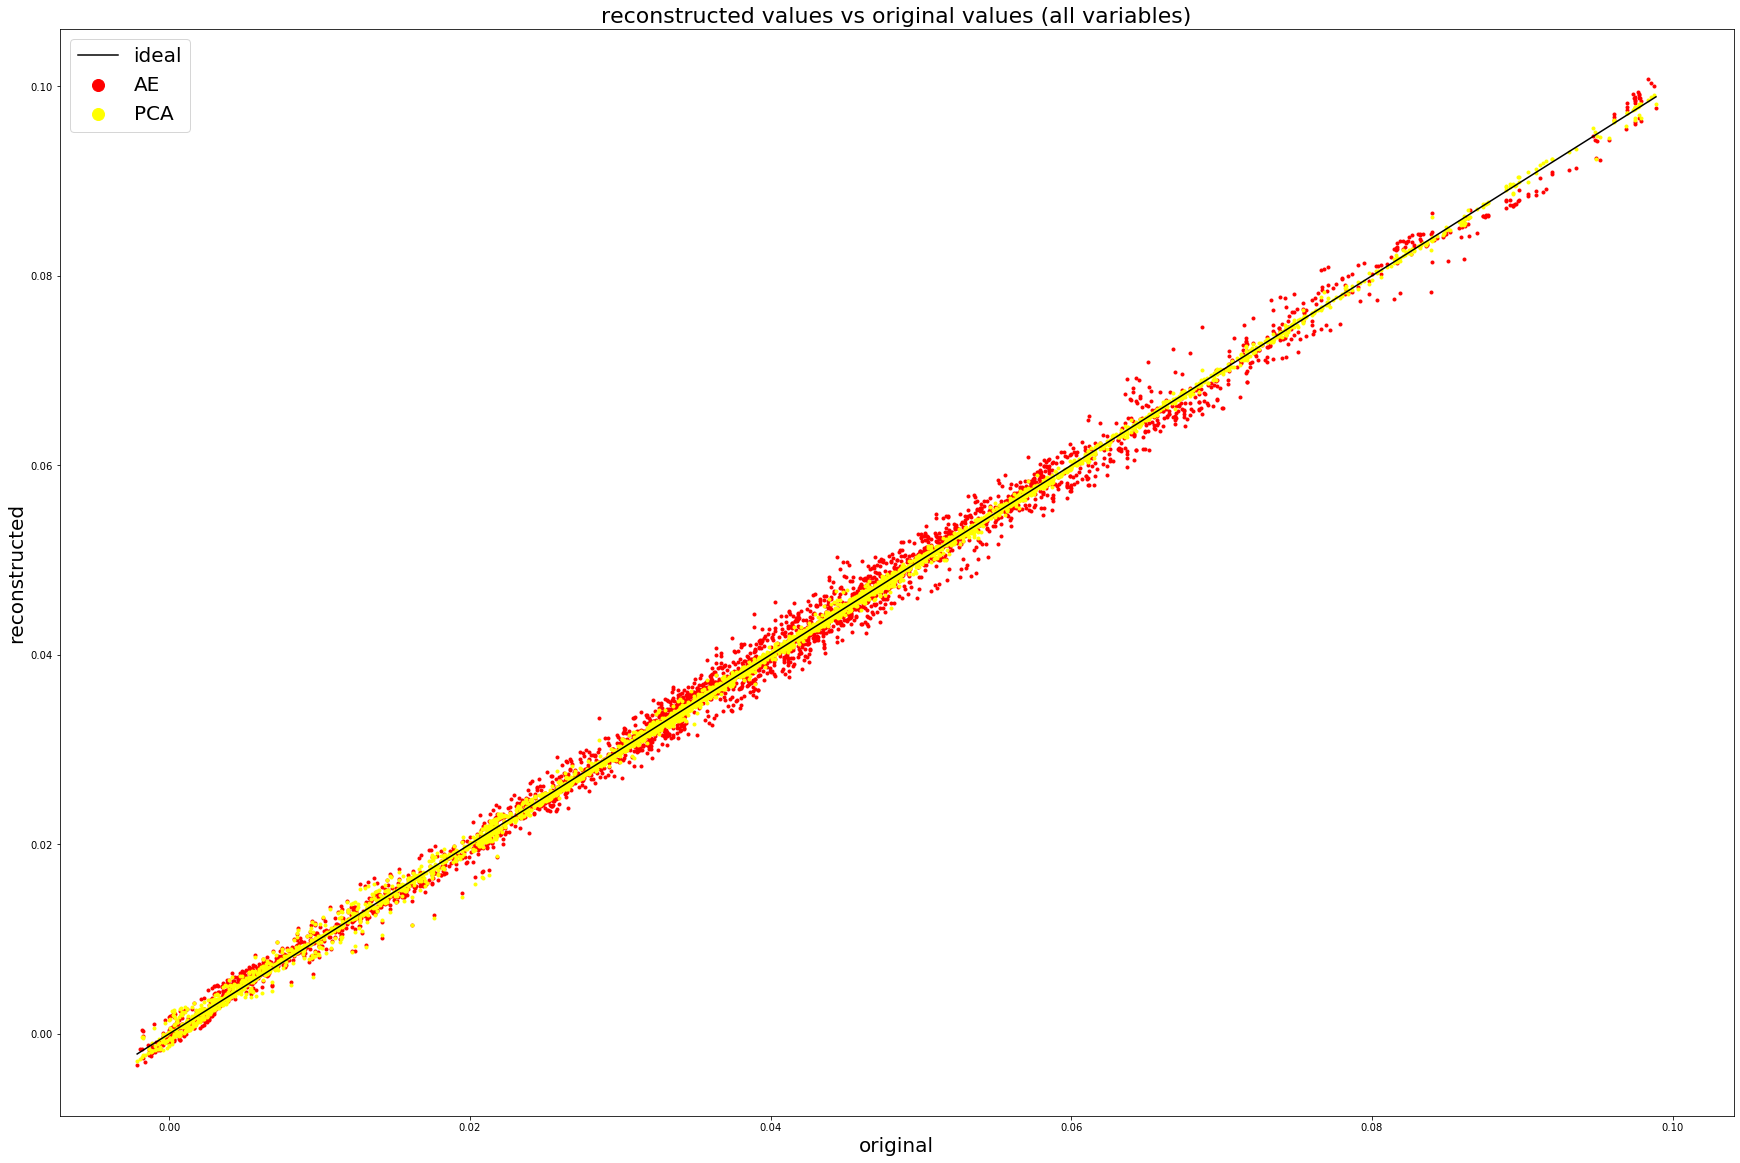

In [31]:
plt.figure(figsize=(30,20))
plt.title('reconstructed values vs original values (all variables)'
         , fontsize=22)
xy = np.linspace(df.values.min(), df.values.max(), 2)

plt.plot(xy, xy, c='black') # y = x
plt.scatter(df.values, df_ae_recon, marker='.', c='red') # ae recon vs original data
plt.scatter(df.values, df_pca_recon, marker='.', c='yellow') # pca preimage vs original data

plt.xlabel('original', fontsize=20)
plt.ylabel('reconstructed', fontsize=20)
plt.legend(['ideal', 'AE', 'PCA'], fontsize=20, markerscale=4);

## Visualize the data projected onto the principal components
First show the data on the principal components obtained by PCA. Then show the data using the left singular vectors from the decoder weight matrix.

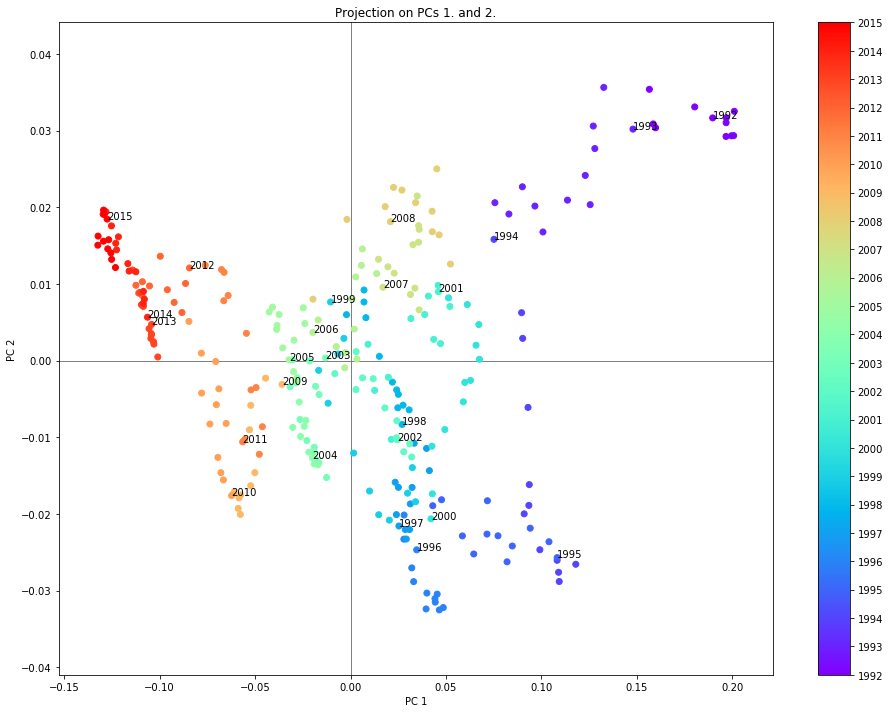

In [32]:
# you may set pc1 or pc2 to the integer index of any column in `df_pca`
pc1 = 0
pc2 = 1

merged_years = 1

fig = plt.figure(figsize=(16,12))
plt.title('Projection on PCs {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey",linewidth=1.0,zorder=0)
    
sc = plt.scatter(df_pca.loc[:, pc1], df_pca.loc[:, pc2], c = [d.year for d in df_pca.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_pca.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_pca.index])[::1])

for year in range(df_pca.index.min().year, df_pca.index.max().year+1, merged_years):
    year_start = df_pca.index[df_pca.index.searchsorted(datetime(year, 1, 1))]
    year_end = df_pca.index[df_pca.index.searchsorted(datetime(year + merged_years-1, 12, 31))]
    
    plt.annotate('{0}'.format(year), xy=(df_pca.loc[year_start, pc1],df_pca.loc[year_start, pc2]), 
                 xytext=(df_pca.loc[year_start,pc1],df_pca.loc[year_start,pc2]));


Now show the data using the left singular vectors from the decoder weight matrix. Note that the sign of the first principal component has been changed for ease of comparison.

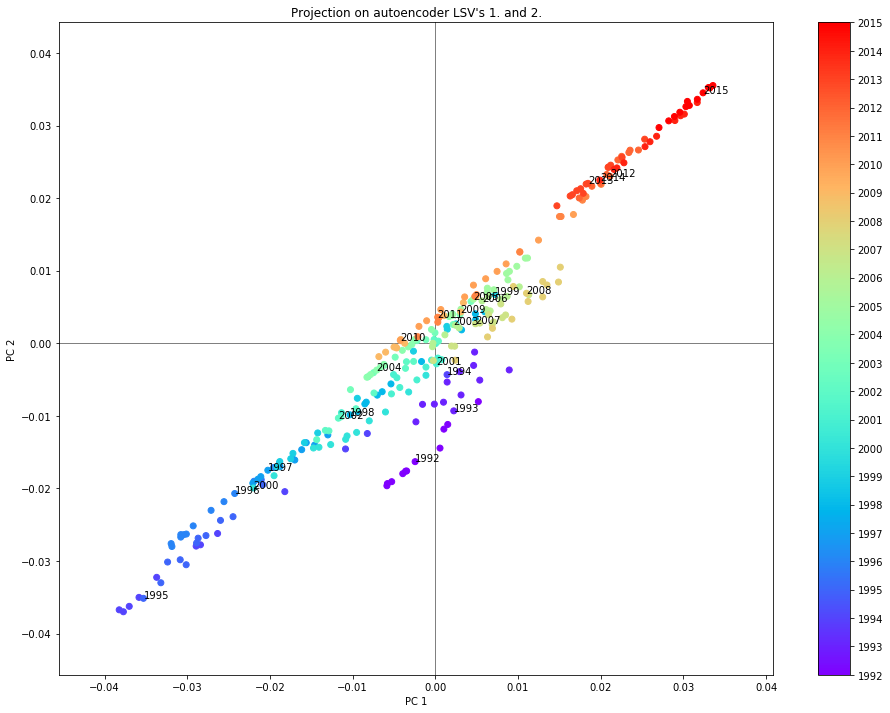

In [33]:
# you may set pc1 or pc2 to the integer index of any column in `df_ae`
pc1 = 0
pc2 = 1

merged_years = 1
fig = plt.figure(figsize=(16, 12))
plt.title('Projection on autoencoder LSV\'s {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey", linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey", linewidth=1.0,zorder=0)
    
sc = plt.scatter(-df_ae.loc[:,pc1], df_ae.loc[:,pc2], 
                 c=[d.year for d in df_ae.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_ae.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_ae.index])[::1])

for year in range(df_ae.index.min().year, df_ae.index.max().year+1, merged_years):
    year_start = df_ae.index[df_ae.index.searchsorted(datetime(year,1,1))]
    year_end = df_ae.index[df_ae.index.searchsorted(datetime(year+merged_years-1,12,31))]
    plt.annotate('{0}'.format(year), xy=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), 
                 xytext=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]));

### Plot the reconstruction error of the linear autoencoder per variable

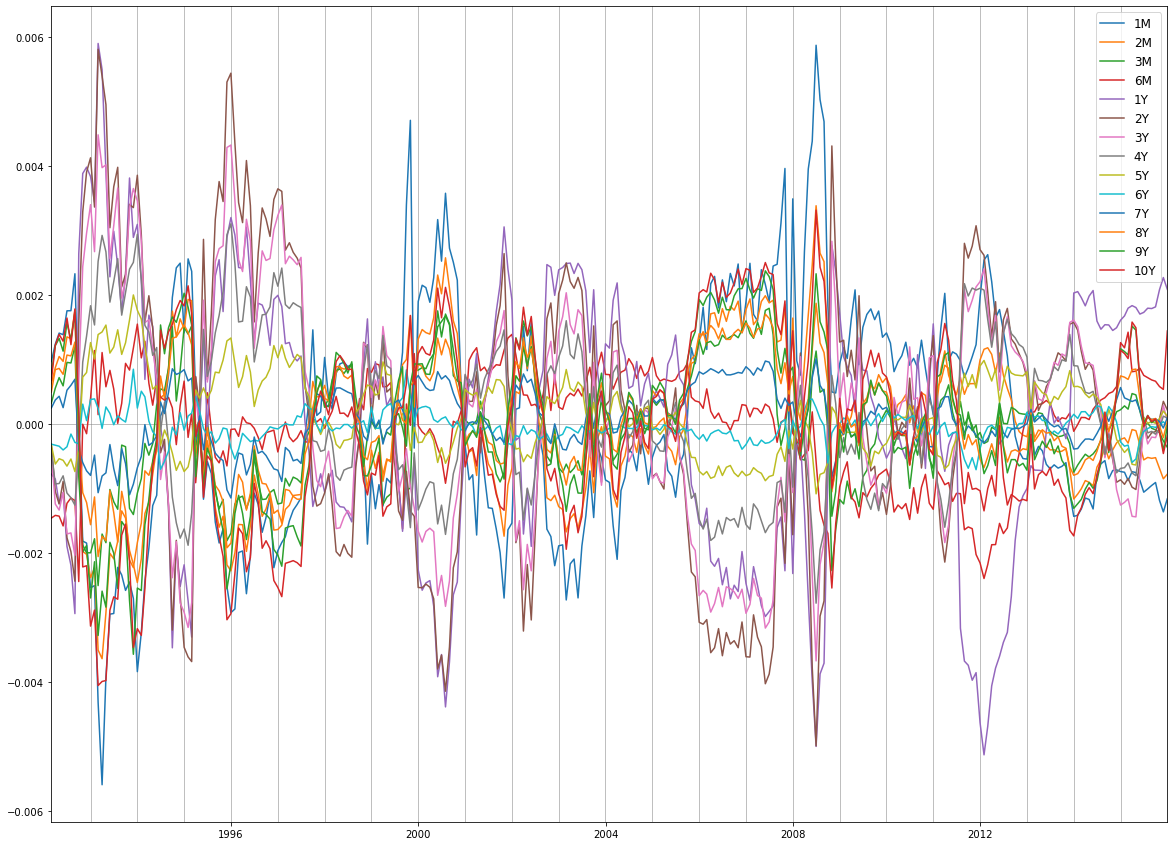

In [34]:
plt.figure(figsize=(20,15))
plt.plot(df.index, pd.DataFrame(df_ae_recon - df))
plt.legend(df.columns, fontsize=12, loc='upper right')
plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

## Deep Autoencoders

This nonlinear autoencoder architecture has two encoder and two decoder layers, each with the $tanh$ activation function. 

The first layer reduces the input to a set of `2*dimension` features, and the second halves this to `dimension`. 

The two decoder layers reverse this process, increasing the number of units in each layer first to half the original number of variables and then back into the input space.

In [35]:
def DeepAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input = Input(shape=(y.shape[1],))
    encoded1 = Dense(np.int(2*dimension), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(input)
    encoded2 = Dense(dimension, activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded1)
    decoded1 = Dense(np.int(y.shape[1]/2), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded2)
    decoded2 = Dense(y.shape[1], activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(decoded1)
    
    autoencoder = models.Model(input, decoded2)
    autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate), loss='mean_squared_error')
    
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [36]:
deepAE_model = DeepAE(df, 3, regularization=0, epochs=1000)

Epoch 1/1000
287/287 [==============================] - 1s 4ms/step - loss: 0.0019
Epoch 2/1000
287/287 [==============================] - 0s 693us/step - loss: 0.0012
Epoch 3/1000
287/287 [==============================] - 0s 765us/step - loss: 8.5853e-04
Epoch 4/1000
287/287 [==============================] - 0s 776us/step - loss: 6.5966e-04
Epoch 5/1000
287/287 [==============================] - 0s 692us/step - loss: 5.3416e-04
Epoch 6/1000
287/287 [==============================] - 0s 719us/step - loss: 4.5428e-04
Epoch 7/1000
287/287 [==============================] - 0s 719us/step - loss: 4.0412e-04
Epoch 8/1000
287/287 [==============================] - 0s 725us/step - loss: 3.7152e-04
Epoch 9/1000
287/287 [==============================] - 0s 728us/step - loss: 3.4925e-04
Epoch 10/1000
287/287 [==============================] - 0s 683us/step - loss: 3.3279e-04
Epoch 11/1000
287/287 [==============================] - 0s 658us/step - loss: 3.1952e-04
Epoch 12/1000
287/287 [======

287/287 [==============================] - 0s 609us/step - loss: 1.8587e-05
Epoch 93/1000
287/287 [==============================] - 0s 608us/step - loss: 1.8562e-05
Epoch 94/1000
287/287 [==============================] - 0s 606us/step - loss: 1.8544e-05
Epoch 95/1000
287/287 [==============================] - ETA: 0s - loss: 1.8222e-0 - 0s 626us/step - loss: 1.8420e-05
Epoch 96/1000
287/287 [==============================] - 0s 620us/step - loss: 1.8511e-05
Epoch 97/1000
287/287 [==============================] - 0s 716us/step - loss: 1.8285e-05
Epoch 98/1000
287/287 [==============================] - 0s 656us/step - loss: 1.8349e-05
Epoch 99/1000
287/287 [==============================] - 0s 699us/step - loss: 1.8366e-05
Epoch 100/1000
287/287 [==============================] - 0s 704us/step - loss: 1.8161e-05
Epoch 101/1000
287/287 [==============================] - 0s 610us/step - loss: 1.8018e-05
Epoch 102/1000
287/287 [==============================] - 0s 702us/step - loss: 1.81

Epoch 182/1000
287/287 [==============================] - 0s 640us/step - loss: 4.1376e-06
Epoch 183/1000
287/287 [==============================] - 0s 666us/step - loss: 3.9906e-06
Epoch 184/1000
287/287 [==============================] - 0s 643us/step - loss: 3.8778e-06
Epoch 185/1000
287/287 [==============================] - 0s 655us/step - loss: 3.7763e-06
Epoch 186/1000
287/287 [==============================] - 0s 659us/step - loss: 3.6801e-06
Epoch 187/1000
287/287 [==============================] - 0s 655us/step - loss: 3.5259e-06
Epoch 188/1000
287/287 [==============================] - 0s 642us/step - loss: 3.5331e-06
Epoch 189/1000
287/287 [==============================] - 0s 636us/step - loss: 3.4444e-06
Epoch 190/1000
287/287 [==============================] - 0s 657us/step - loss: 3.3378e-06
Epoch 191/1000
287/287 [==============================] - 0s 624us/step - loss: 3.2927e-06
Epoch 192/1000
287/287 [==============================] - 0s 629us/step - loss: 3.2628e-06

287/287 [==============================] - 0s 653us/step - loss: 1.7969e-06
Epoch 273/1000
287/287 [==============================] - 0s 661us/step - loss: 1.7442e-06
Epoch 274/1000
287/287 [==============================] - 0s 706us/step - loss: 1.7551e-06
Epoch 275/1000
287/287 [==============================] - 0s 755us/step - loss: 1.7356e-06
Epoch 276/1000
287/287 [==============================] - 0s 738us/step - loss: 1.7634e-06
Epoch 277/1000
287/287 [==============================] - 0s 793us/step - loss: 1.7258e-06
Epoch 278/1000
287/287 [==============================] - 0s 816us/step - loss: 1.7353e-06
Epoch 279/1000
287/287 [==============================] - 0s 732us/step - loss: 1.7388e-06
Epoch 280/1000
287/287 [==============================] - 0s 786us/step - loss: 1.7053e-06
Epoch 281/1000
287/287 [==============================] - 0s 762us/step - loss: 1.6972e-06
Epoch 282/1000
287/287 [==============================] - 0s 679us/step - loss: 1.6994e-06
Epoch 283/1000

287/287 [==============================] - 0s 655us/step - loss: 1.4464e-06
Epoch 363/1000
287/287 [==============================] - 0s 689us/step - loss: 1.4586e-06
Epoch 364/1000
287/287 [==============================] - 0s 655us/step - loss: 1.4508e-06
Epoch 365/1000
287/287 [==============================] - 0s 642us/step - loss: 1.4764e-06
Epoch 366/1000
287/287 [==============================] - 0s 619us/step - loss: 1.4377e-06
Epoch 367/1000
287/287 [==============================] - 0s 631us/step - loss: 1.4548e-06
Epoch 368/1000
287/287 [==============================] - 0s 684us/step - loss: 1.4309e-06
Epoch 369/1000
287/287 [==============================] - 0s 617us/step - loss: 1.4368e-06
Epoch 370/1000
287/287 [==============================] - 0s 579us/step - loss: 1.4153e-06
Epoch 371/1000
287/287 [==============================] - 0s 626us/step - loss: 1.4187e-06
Epoch 372/1000
287/287 [==============================] - 0s 613us/step - loss: 1.4107e-06
Epoch 373/1000

287/287 [==============================] - 0s 601us/step - loss: 1.1448e-06
Epoch 453/1000
287/287 [==============================] - 0s 600us/step - loss: 1.1510e-06
Epoch 454/1000
287/287 [==============================] - 0s 597us/step - loss: 1.1481e-06
Epoch 455/1000
287/287 [==============================] - 0s 614us/step - loss: 1.1377e-06
Epoch 456/1000
287/287 [==============================] - 0s 617us/step - loss: 1.1366e-06
Epoch 457/1000
287/287 [==============================] - 0s 622us/step - loss: 1.1314e-06
Epoch 458/1000
287/287 [==============================] - 0s 620us/step - loss: 1.1603e-06
Epoch 459/1000
287/287 [==============================] - 0s 605us/step - loss: 1.1221e-06
Epoch 460/1000
287/287 [==============================] - 0s 595us/step - loss: 1.1477e-06
Epoch 461/1000
287/287 [==============================] - 0s 598us/step - loss: 1.1409e-06
Epoch 462/1000
287/287 [==============================] - 0s 613us/step - loss: 1.1379e-06
Epoch 463/1000

287/287 [==============================] - 0s 725us/step - loss: 8.4855e-07
Epoch 543/1000
287/287 [==============================] - 0s 683us/step - loss: 8.4135e-07
Epoch 544/1000
287/287 [==============================] - 0s 702us/step - loss: 8.2785e-07
Epoch 545/1000
287/287 [==============================] - 0s 744us/step - loss: 8.4394e-07
Epoch 546/1000
287/287 [==============================] - 0s 674us/step - loss: 8.3653e-07
Epoch 547/1000
287/287 [==============================] - 0s 644us/step - loss: 8.2592e-07
Epoch 548/1000
287/287 [==============================] - 0s 669us/step - loss: 8.3656e-07
Epoch 549/1000
287/287 [==============================] - 0s 696us/step - loss: 8.1185e-07
Epoch 550/1000
287/287 [==============================] - 0s 709us/step - loss: 8.0297e-07
Epoch 551/1000
287/287 [==============================] - 0s 661us/step - loss: 8.0262e-07
Epoch 552/1000
287/287 [==============================] - 0s 711us/step - loss: 8.4704e-07
Epoch 553/1000

287/287 [==============================] - 0s 686us/step - loss: 5.7321e-07
Epoch 633/1000
287/287 [==============================] - 0s 641us/step - loss: 5.7394e-07
Epoch 634/1000
287/287 [==============================] - 0s 633us/step - loss: 5.7612e-07
Epoch 635/1000
287/287 [==============================] - 0s 656us/step - loss: 5.8121e-07
Epoch 636/1000
287/287 [==============================] - 0s 613us/step - loss: 5.6027e-07
Epoch 637/1000
287/287 [==============================] - 0s 600us/step - loss: 5.6653e-07
Epoch 638/1000
287/287 [==============================] - 0s 601us/step - loss: 5.6988e-07
Epoch 639/1000
287/287 [==============================] - 0s 608us/step - loss: 5.7574e-07
Epoch 640/1000
287/287 [==============================] - 0s 640us/step - loss: 5.7368e-07
Epoch 641/1000
287/287 [==============================] - 0s 634us/step - loss: 5.4848e-07
Epoch 642/1000
287/287 [==============================] - 0s 669us/step - loss: 5.5512e-07
Epoch 643/1000

287/287 [==============================] - 0s 662us/step - loss: 4.4114e-07
Epoch 723/1000
287/287 [==============================] - 0s 712us/step - loss: 4.3997e-07
Epoch 724/1000
287/287 [==============================] - 0s 728us/step - loss: 4.4099e-07
Epoch 725/1000
287/287 [==============================] - 0s 683us/step - loss: 4.3718e-07
Epoch 726/1000
287/287 [==============================] - 0s 621us/step - loss: 4.4143e-07
Epoch 727/1000
287/287 [==============================] - 0s 716us/step - loss: 4.4423e-07
Epoch 728/1000
287/287 [==============================] - 0s 639us/step - loss: 4.3666e-07
Epoch 729/1000
287/287 [==============================] - 0s 676us/step - loss: 4.4824e-07
Epoch 730/1000
287/287 [==============================] - 0s 655us/step - loss: 4.4379e-07
Epoch 731/1000
287/287 [==============================] - 0s 622us/step - loss: 4.4370e-07
Epoch 732/1000
287/287 [==============================] - 0s 612us/step - loss: 4.3792e-07
Epoch 733/1000

287/287 [==============================] - 0s 632us/step - loss: 3.9933e-07
Epoch 813/1000
287/287 [==============================] - 0s 646us/step - loss: 3.9649e-07
Epoch 814/1000
287/287 [==============================] - 0s 604us/step - loss: 3.9978e-07
Epoch 815/1000
287/287 [==============================] - 0s 655us/step - loss: 4.0470e-07
Epoch 816/1000
287/287 [==============================] - 0s 669us/step - loss: 4.0178e-07
Epoch 817/1000
287/287 [==============================] - 0s 653us/step - loss: 3.9671e-07
Epoch 818/1000
287/287 [==============================] - 0s 642us/step - loss: 3.8553e-07
Epoch 819/1000
287/287 [==============================] - 0s 630us/step - loss: 3.8770e-07
Epoch 820/1000
287/287 [==============================] - 0s 624us/step - loss: 3.8660e-07
Epoch 821/1000
287/287 [==============================] - 0s 619us/step - loss: 3.9385e-07
Epoch 822/1000
287/287 [==============================] - 0s 602us/step - loss: 4.0263e-07
Epoch 823/1000

287/287 [==============================] - 0s 624us/step - loss: 3.7535e-07
Epoch 903/1000
287/287 [==============================] - 0s 590us/step - loss: 3.7619e-07
Epoch 904/1000
287/287 [==============================] - 0s 595us/step - loss: 3.7356e-07
Epoch 905/1000
287/287 [==============================] - 0s 605us/step - loss: 3.6768e-07
Epoch 906/1000
287/287 [==============================] - 0s 597us/step - loss: 3.6919e-07
Epoch 907/1000
287/287 [==============================] - 0s 615us/step - loss: 3.6909e-07
Epoch 908/1000
287/287 [==============================] - 0s 628us/step - loss: 3.8401e-07
Epoch 909/1000
287/287 [==============================] - 0s 614us/step - loss: 3.7537e-07
Epoch 910/1000
287/287 [==============================] - 0s 616us/step - loss: 3.7530e-07
Epoch 911/1000
287/287 [==============================] - 0s 614us/step - loss: 3.7158e-07
Epoch 912/1000
287/287 [==============================] - 0s 610us/step - loss: 3.8312e-07
Epoch 913/1000

Epoch 992/1000
287/287 [==============================] - 0s 699us/step - loss: 3.6306e-07
Epoch 993/1000
287/287 [==============================] - 0s 789us/step - loss: 3.6355e-07
Epoch 994/1000
287/287 [==============================] - 0s 763us/step - loss: 3.8115e-07
Epoch 995/1000
287/287 [==============================] - 0s 747us/step - loss: 3.6576e-07
Epoch 996/1000
287/287 [==============================] - 0s 821us/step - loss: 3.6240e-07
Epoch 997/1000
287/287 [==============================] - 0s 740us/step - loss: 3.6334e-07
Epoch 998/1000
287/287 [==============================] - 0s 655us/step - loss: 3.5726e-07
Epoch 999/1000
287/287 [==============================] - 0s 691us/step - loss: 3.6156e-07
Epoch 1000/1000
287/287 [==============================] - 0s 667us/step - loss: 3.7226e-07


### Plot the reconstruction error of the deep autoencoder per variable

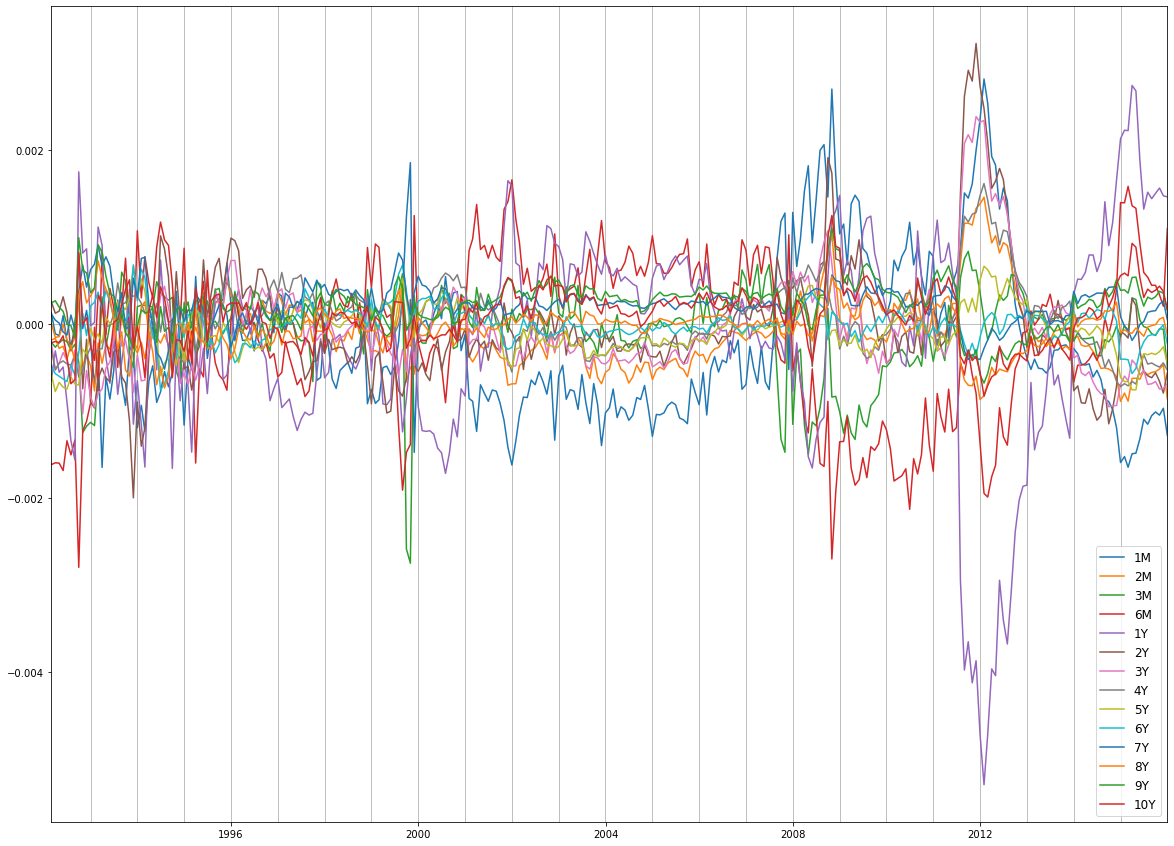

In [37]:
df_deep_recon = deepAE_model.predict(df)

plt.figure(figsize=(20, 15))
plt.plot(df.index, pd.DataFrame(df_deep_recon - df))
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i, 1, 1)) - 1],
                c="grey", linewidth=0.5, zorder=0)

### Compare reconstruction errors for Linear AE, Deep AE, and PCA

The reconstruction error is the orthogonal distance between the original datapoint and the subspace. Further tuning is required, but the Deep AE exhibits much lower reconstruction error than the linear AE and is comparable to PCA.

In [38]:
pca_rec_errs = np.sqrt(np.sum((df_pca_recon - df)**2, axis=1))

ae_rec_errs = np.sqrt(np.sum((df_ae_recon - df)**2, axis=1))

deep_rec_errs = np.sqrt(np.sum((df_deep_recon - df)**2, axis=1))

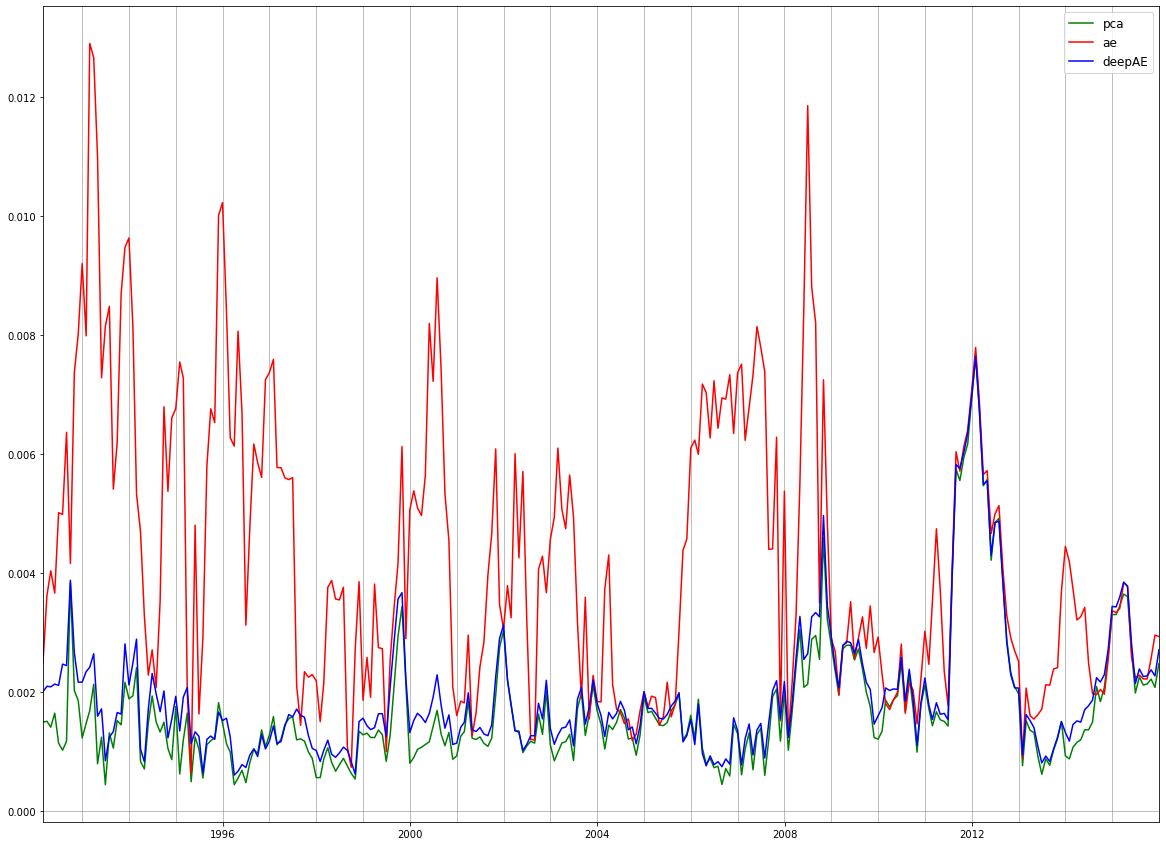

In [39]:
plt.figure(figsize=(20, 15))
plt.plot(df.index, pca_rec_errs, c='green')
plt.plot(df.index, ae_rec_errs, c='red')
plt.plot(df.index, deep_rec_errs, c='blue')
plt.legend(['pca','ae','deepAE'], fontsize=12)
plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i, 1, 1)) - 1],
                c="grey", linewidth=0.5, zorder=0)